# Reproducing “Characterization of Term and Preterm Deliveries using Electrohysterograms Signatures”

In this problem, we will reproduce the results from

M. U. Khan, S. Aziz, S. Ibraheem, A. Butt and H. Shahid, "Characterization of Term and Preterm Deliveries using Electrohysterograms Signatures," 2019 IEEE 10th Annual Information Technology, Electronics and Mobile Communication Conference (IEMCON), Vancouver, BC, Canada, 2019, pp. 0899-0905, doi: 10.1109/IEMCON.2019.8936292. [PDF](https://us.prairielearn.com/pl/course_instance/175646/instance_question/504680337/clientFilesQuestion/Characterization_of_Term_and_Preterm_Deliveries_using_Electrohysterograms_Signatures.pdf)

which predicts pre-term birth based on raw EHG (electrohysterography) signals from pregnant women. It claims an accuracy of 95.5% on the test set using an SVM classifier with RBF kernel. We will follow the steps described in the paper to try and achieve a similar accuracy.

However, it turns out - as discussed in

Gilles Vandewiele, Isabelle Dehaene, György Kovács, Lucas Sterckx, Olivier Janssens, Femke Ongenae, Femke De Backere, Filip De Turck, Kristien Roelens, Johan Decruyenaere, Sofie Van Hoecke, Thomas Demeester, "Overly optimistic prediction results on imbalanced data: a case study of flaws and benefits when applying over-sampling", Artificial Intelligence in Medicine, Volume 111, 2021, 101987, ISSN 0933-3657. [PDF](https://arxiv.org/pdf/2001.06296)

that the reported 95.5% accuracy is much higher than we would achieve on new EHG signals when the model is used in practice. This is because the procedure described in the paper oversamples the dataset before splitting it into training and test sets. Consequently, test set samples are used to generate synthetic samples for the training set, and training set samples are used to generate synthetic samples for the test set.

We will repeat the original pre-term birth prediction, but without the data leakage error - we keep training and test sets separate in oversampling, rather than oversampling all together. We show that the original accuracy was based on an "overly optimistic" evaluation, and the true performance of the model is much less.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We will use the following random state throughout this notebook, in any function calls that involve randomness:

In [3]:
random_state = 83


In this notebook, we will reproduce the results published in 

> M. U. Khan, S. Aziz, S. Ibraheem, A. Butt and H. Shahid, "Characterization of Term and Preterm Deliveries using Electrohysterograms Signatures," 2019 IEEE 10th Annual Information Technology, Electronics and Mobile Communication Conference (IEMCON), Vancouver, BC, Canada, 2019, pp. 0899-0905, doi: 10.1109/IEMCON.2019.8936292. [PDF](/Characterization_of_Term_and_Preterm_Deliveries_using_Electrohysterograms_Signatures.pdf)

Preterm birth occurs when a baby is born before 37 weeks of pregnancy.  This notebook aims to reproduce the results of a study exploring the use of electrohysterograms (EHG) signatures to predict whether a delivery will be term or preterm.




In this notebook, we will first use an *incorrect* approach described in Khan et al., then we will fix their error and evaluate a correct version of their model.

## Read in data

The data we will use comes from the Term-Preterm EHG Database, a collection of EHG signals obtained from 1997 to 2005 at the University Medical Centre Ljubljana, Department of Obstetrics and Gynecology. 

Electrohysterogram signature is obtained by placing four electrodes on the abdomen of the mother, to measure the electrical activity of the uterine muscle.

The TPEHG databage consists of EHG records obtained from 262 women who had full-term pregnancies and 38 whose pregnancies ended prematurely. The records were obtained during regular check-ups either around the 22nd week of gestation or around the 32nd week of gestation. 

In this study, the raw EHG data were further processed to create "transformed" features from each channel: Median frequency, Shannon energy, Log energy, and Lyapunov exponent. We have already pre-computed these features.

Let's read in the data now - 

In [4]:
features = pd.read_csv("raw_features.csv")       # read in as data frame
y = pd.read_csv("target.csv").squeeze("columns") # read in as data series

We know that there is a class imbalance in this data - there are many more term births (label 1) than pre-term births (label 0). Let's confirm:

In [5]:
y.value_counts()

0
1.0    260
0.0     38
Name: count, dtype: int64

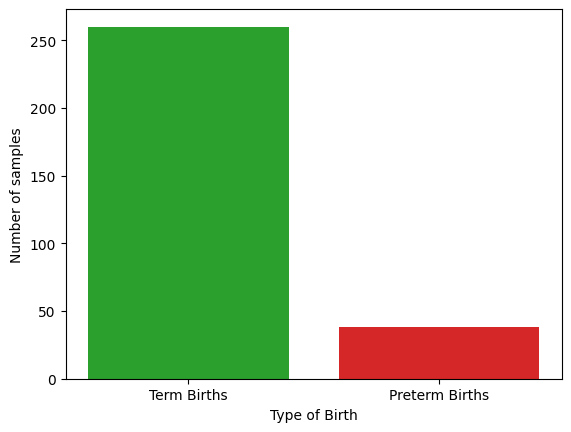

In [6]:
plt.bar(['Term Births','Preterm Births'],height=[y.value_counts()[1],y.value_counts()[0]],color=['tab:green','tab:red']);
plt.ylabel("Number of samples");
plt.xlabel("Type of Birth");


Our "features" data file includes many engineered features computed from the raw EHG symbols, we will focus specifically on the features used by Khan et al. in the paper we are trying to reproduce:

In [7]:
khan_features = [
    'FeaturesJager_fmed_ch1', 'FeaturesJager_max_lyap_ch1',
    'FeaturesJager_sampen_ch1', 'FeaturesJager_fmed_ch2',
    'FeaturesJager_max_lyap_ch2', 'FeaturesJager_sampen_ch2',
    'FeaturesJager_fmed_ch3', 'FeaturesJager_max_lyap_ch3',
    'FeaturesJager_sampen_ch3',
 ]
generic_features=[ c for c in features.columns if 'FeaturesAcharya' in c and 'SampleEntropy' in c ]

X = features[khan_features + generic_features]


In [8]:
X.head()

,FeaturesJager_fmed_ch1,FeaturesJager_max_lyap_ch1,FeaturesJager_sampen_ch1,FeaturesJager_fmed_ch2,FeaturesJager_max_lyap_ch2,FeaturesJager_sampen_ch2,FeaturesJager_fmed_ch3,FeaturesJager_max_lyap_ch3,FeaturesJager_sampen_ch3,FeaturesAcharya__emd_0_FeatureSampleEntropy_ch1,...,FeaturesAcharya_aa_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaa_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaaa_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaaaa_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaaaaa_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_d_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_ad_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aad_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaad_emd_10_FeatureSampleEntropy_ch3,FeaturesAcharya_aaaad_emd_10_FeatureSampleEntropy_ch3
0,0.154949,0.094890,0.676284,0.133788,0.095959,0.519813,0.145392,0.096591,0.662972,0.780728,...,0.002089,0.004196,0.008464,0.017284,0.035785,0.000137,0.000273,0.000547,0.000002,0.002207
1,0.157333,0.097758,0.703688,0.242667,0.108000,0.668954,0.146667,0.100279,0.621924,0.854168,...,0.006125,0.012379,0.025282,0.052865,0.116388,0.000133,0.000267,0.000535,0.001072,0.002153
2,0.205479,0.101883,0.967597,0.149315,0.100426,0.647371,0.164384,0.105308,0.902851,0.739980,...,0.003374,0.006796,0.013789,0.028368,0.060065,0.000137,0.000274,0.000549,0.001101,0.002212
3,1.611604,0.077030,0.768602,0.148123,0.118442,0.678978,1.529010,0.078359,0.750013,0.362578,...,0.011388,0.023158,0.047877,0.102714,0.225879,0.000137,0.000273,0.000547,0.001098,0.002205
4,0.146667,0.107116,0.815574,0.220667,0.116404,0.839187,0.168000,0.103709,0.696235,0.740482,...,0.003889,0.007802,0.015694,0.031770,0.065176,0.000133,0.000267,0.000535,0.001071,0.002153


## 1. Train an SVM classifier - baseline

Because of the small number of samples, and especially the small number of samples in the minority class, it is not practical to divide this data into a single training set and held-out test set. The results would be highly dependent on the specific division of samples. 

Instead, we will *evaluate* our model using a K-fold CV - we will consider the average accuracy across folds as our test set accuracy. This is different from *selecting* a model using a validation set inside K-fold CV. We will have a single loop over folds, and in each iteration, we will train the *same* model (on a different training subset) and then evaluate that model on a test subset.


Inside the following cell:

* Set up a `KFold` CV loop with `nfold = 3` splits. Since we have *not* previously shuffled the data, make sure to shuffle it here, and use the random state defined in the `random_state` variable.
* Inside the `KFold` CV loop, use the training and test indices provided by the `KFold` to select the appropriate rows of `X` and `y`. Since they are a `pandas` data frame/series and not a `numpy` array, use `.iloc` to select rows by integer index. Save these subsets of the data as `Xtr_kfold`, `Xts_kfold`, `ytr_kfold`, and `yts_kfold`.
* Then, train an SVM model on the training subset. Use the `rbf` kernel, the random state defined in the `random_state` variable, `gamma = 0.1`, and `C = 10`.
* Get the predictions of the model on the test subset in this fold. Save these in `yhat_ts`.
* We will record four classifier metrics for each fold, but code is already provided for you to use to record:
    * accuracy (saved in `acc_ts_base`)
    * balanced accuracy (saved in `bal_ts_base`)
    * sensitivity (saved in `sen_ts_base`)
    * specificity (saved in `spe_ts_base`)
    * and we will also save the data to generate the confusion matrix (saved in `cm_ts_base`)

In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 3
acc_ts_base = np.zeros(nfold)
bal_ts_base = np.zeros(nfold)
sen_ts_base = np.zeros(nfold)
spe_ts_base = np.zeros(nfold)
cm_ts_base  = np.zeros(shape = (2, 2, nfold))

kf = KFold(n_splits=nfold, shuffle=True, random_state=random_state)
for isplit, (train_index, test_index) in enumerate(kf.split(X, y)):
    Xtr_kfold = X.iloc[train_index]
    Xts_kfold = X.iloc[test_index]
    ytr_kfold = y.iloc[train_index]
    yts_kfold = y.iloc[test_index]

    clf = SVC(kernel='rbf', random_state=random_state, gamma=0.1, C=10)
    clf.fit(Xtr_kfold, ytr_kfold)
    yhat_ts = clf.predict(Xts_kfold)

    acc_ts_base[isplit] = accuracy_score(yts_kfold, yhat_ts)
    bal_ts_base[isplit] = balanced_accuracy_score(yts_kfold, yhat_ts)
    sen_ts_base[isplit] = recall_score(yts_kfold, yhat_ts)
    spe_ts_base[isplit] = recall_score(yts_kfold, yhat_ts, pos_label=0)
    cm_ts_base[:, :, isplit] = confusion_matrix(yts_kfold, yhat_ts, labels=[0, 1])


Let's see the average performance:

In [10]:
print("Accuracy:    ", acc_ts_base.mean())

Accuracy:     0.8691245791245791


However, since there is a class imbalance, a high accuracy alone does not mean that the classifier is effective. 

In [11]:
print("Bal Accuracy: ", bal_ts_base.mean())

Bal Accuracy:  0.51010101010101


We can see some hints about the problem if we look at the model's sensitivity (what proportion of the true positive - term birth - samples are correctly predicted as positive?) and specificity (what proportion of the true negative - pre-term birth - samples are correctly predicted as negative?):

In [12]:
print("Sensitivity: ", sen_ts_base.mean())
print("Specificity: ", spe_ts_base.mean())

Sensitivity:  0.9924242424242425
Specificity:  0.027777777777777776


In our K-fold CV loop, we also saved the confusion matrix in each fold. Let's look at those now:

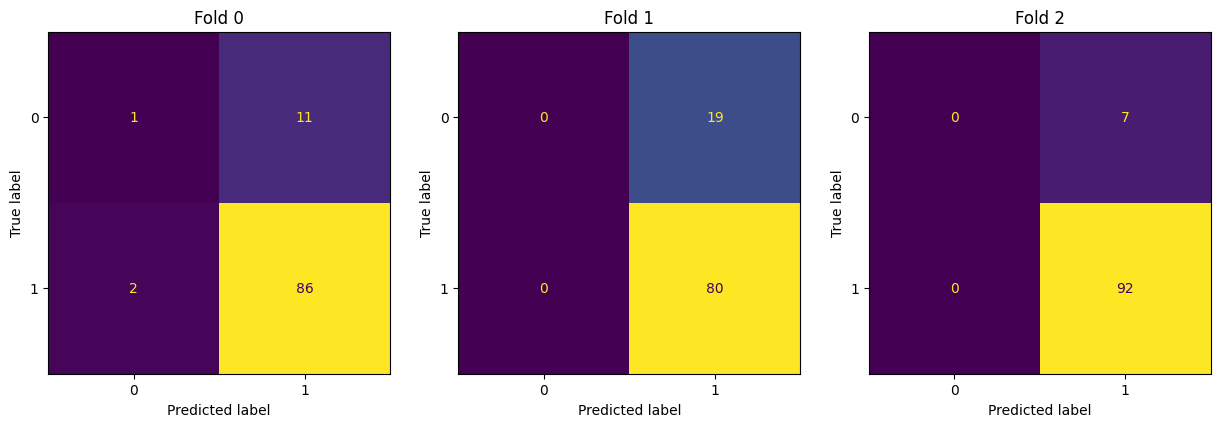

In [13]:
f, axes = plt.subplots(1, nfold, figsize = (nfold*5, 5))
for i in range(nfold):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_ts_base[:, :, i],
                              display_labels = [0, 1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title("Fold %d" % i)
    disp.im_.colorbar.remove()


We can see two problems:

1. The classifier always or almost always predicts the majority class, label 1. It is essentially doing "prediction by mode".
2. We also note that the proportion of test samples belonging to the minority class - the number of samples where the "true label" is 0 - varies wildly across folds, from less than 10% to close to 20%.

## 2. Train an SVM classifier - stratified split

The second problem is easy to fix. To make sure that the ratio of the class labels is similar across folds, we can use a [`StratifiedKFold`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html) instead of the `KFold`.

Copy your code from Part 1, but replace the `KFold` with a `StratifiedKFold` to ensure that the distribution of `y` is consistent across folds. Otherwise, keep everything else the same.

You will save the same metrics as before, in:
* accuracy (`acc_ts_strat`)
* balanced accuracy (`bal_ts_strat`)
* sensitivity (`sen_ts_strat`)
* specificity (`spe_ts_strat`)
* and the data to generate the confusion matrix (`cm_ts_strat`)


In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 3

acc_ts_strat = np.zeros(nfold)
bal_ts_strat = np.zeros(nfold)
sen_ts_strat = np.zeros(nfold)
spe_ts_strat = np.zeros(nfold)

cm_ts_strat  = np.zeros(shape = (2, 2, nfold))

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_state)
for isplit, (train_index, test_index) in enumerate(skf.split(X, y)):
    Xtr_kfold = X.iloc[train_index]
    Xts_kfold = X.iloc[test_index]
    ytr_kfold = y.iloc[train_index]
    yts_kfold = y.iloc[test_index]

    clf = SVC(kernel='rbf', random_state=random_state, gamma=0.1, C=10)
    clf.fit(Xtr_kfold, ytr_kfold)
    yhat_ts = clf.predict(Xts_kfold)

    acc_ts_strat[isplit] = accuracy_score(yts_kfold, yhat_ts)
    bal_ts_strat[isplit] = balanced_accuracy_score(yts_kfold, yhat_ts)
    sen_ts_strat[isplit] = recall_score(yts_kfold, yhat_ts)
    spe_ts_strat[isplit] = recall_score(yts_kfold, yhat_ts, pos_label=0)
    cm_ts_strat[:, :, isplit] = confusion_matrix(yts_kfold, yhat_ts, labels=[0, 1])




In [15]:
print("Accuracy:     ", acc_ts_strat.mean())
print("Bal Accuracy: ", bal_ts_strat.mean())
print("Sensitivity:  ", sen_ts_strat.mean())
print("Specificity:  ", spe_ts_strat.mean())

Accuracy:      0.8658585858585859
Bal Accuracy:  0.5081417624521073
Sensitivity:   0.9885057471264368
Specificity:   0.027777777777777776


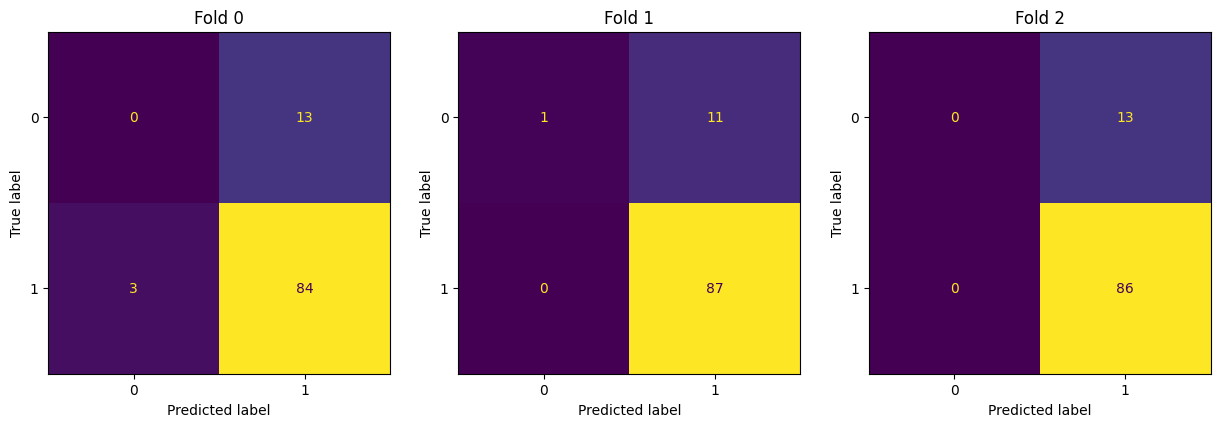

In [16]:
f, axes = plt.subplots(1, nfold, figsize = (nfold*5, 5))
for i in range(nfold):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_ts_strat[:, :, i],
                              display_labels = [0, 1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title("Fold %d" % i)
    disp.im_.colorbar.remove()


We still have a "prediction by mode" classifier, but at least now, the proportion of the class labels is consistent across folds and consistent with the overall ratio in the data.

## 3. Train an SVM classifier - oversampling

The root cause of the first problem - that the SVM classifier does "prediction by mode" - is the class imbalance. To "force" the classifier to focus on both classes, and not only the majority class, we can consider resampling the data so that the class balance is fair. We will mention two resampling techniques - 

-   **Oversampling**: Generate more samples from the minority class, so that it matches the count of the majority class.
-   **Undersampling**: Remove some samples from the majority class, so that it matches the count of the minority class.

In this example, since we have a very small data set, understampling is not practical. We will try oversampling the minority class.


Khan et al. used ADASYN oversampling, so we will too!


Adaptive Synthetic Sampling (ADASYN) is an oversampling technique in which we generate synthetic samples of the minority class, and focus especially on generating synthetic samples for the minority samples which are *harder to learn*.

ADASYN quantifies the learning difficulty of a minority class sample by calculating the proportion of majority class samples among the sample’s K nearest neighbors. More majority neighbors imply a *harder to learn*
minority sample. 

Here is the ADASYN algorithm in detail:

-   **Calculate the degree of class imbalance**:

$$d=m_s/m_l$$

where $m_s$ is the number of minority class examples and $m_l$ is the
number of majority class examples

-   If $d < d_{th}$ (where $d_{th}$ is a preset threshold for the
    maximum tolerated degree of class imbalance ratio):

    -   **Calculate the number of synthetic data examples that need to
        be generated for the minority class:**

    $$G=(m_l-m_s)\times\beta$$

    where $\beta$ is a parameter used to specify the desired balance
    level after generation of the synthetic data. $\beta=1$ means a
    fully balanced data set is created after generalization process.

    -   For each example $x_i \in \text{minority class}$, **find K nearest
        neighbors based on the Euclidean distance** in n dimensional
        space, and **calculate the ratio** $r_i$ defined as:

    $$r_i=\Delta_i/K,$$  
    $$i= 1, \ldots, m_s$$

    where $\Delta_i$ is the number of examples in the K nearest
    neighbors of $x_i$ that belong to the majority class, therefore
    $r_i \in [0, 1]$.

    -   **Normalize $r_i$** according to

    $$\hat{r_i}=r_i/\sum_{i=1}^{m_s}r_i$$

    -   **Calculate the number of synthetic data examples that need to
        be generated for each minority example $x_i$**:

    $$g_i = \hat{r_i} \times G$$

    -   **For each minority class data example $x_i$, generate $g_i$
        synthetic data examples** according to the following steps:
        -   Loop from 1 to $g_i$ :

            -   Randomly choose one minority example from the K nearest
                neighbors for data $x_i$
            -   Generate the synthetic data example:

            $s_i = x_i + (x_{zi} - x_i) \times \lambda$

            where $\lambda$ is a random number: $\lambda \in [0, 1]$

You may refer to the documentation for the [ADASYN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html) oversampling implementation. 

It is similar to `sklearn` "transformers" that we have worked with before, like `StandardScaler` or `CountVectorizer`; where those transformers had a `fit_transform` method, the `ADASYN` implementation has `fit_resample`.

In the following cell,

* Create an `ADASYN` overampler. Specify the random state from the `random_state` variable defined above, and `n_neighbors = 5`.
* Use it to generate `X_oversamp` and `y_oversamp`, the oversampled feature data and label data respectively.

In [17]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
adasyn = ADASYN(random_state=random_state, n_neighbors=5)
X_oversamp, y_oversamp = adasyn.fit_resample(X, y)


Then, copy your code from Part 2, but 

* split on the oversampled data, not the original data
* when defining `Xtr_fold`, `Xts_kfold`, `ytr_kfold`, `yts_kfold`, select rows from the oversampled data, not the original data.

Otherwise, keep everything else the same.

You will save the same metrics as before, in:
* accuracy (`acc_ts_over`)
* balanced accuracy (`bal_ts_over`)
* sensitivity (`sen_ts_over`)
* specificity (`spe_ts_over`)
* and the data to generate the confusion matrix (`cm_ts_over`)


In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 3
acc_ts_over = np.zeros(nfold)
bal_ts_over = np.zeros(nfold)
sen_ts_over = np.zeros(nfold)
spe_ts_over = np.zeros(nfold)
cm_ts_over  = np.zeros(shape = (2, 2, nfold))

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_state)
for isplit, (train_index, test_index) in enumerate(skf.split(X_oversamp, y_oversamp)):
    Xtr_kfold = X_oversamp.iloc[train_index]
    Xts_kfold = X_oversamp.iloc[test_index]
    ytr_kfold = y_oversamp.iloc[train_index]
    yts_kfold = y_oversamp.iloc[test_index]

    clf = SVC(kernel='rbf', random_state=random_state, gamma=0.1, C=10)
    clf.fit(Xtr_kfold, ytr_kfold)
    yhat_ts = clf.predict(Xts_kfold)

    acc_ts_over[isplit] = accuracy_score(yts_kfold, yhat_ts)
    bal_ts_over[isplit] = balanced_accuracy_score(yts_kfold, yhat_ts)
    sen_ts_over[isplit] = recall_score(yts_kfold, yhat_ts)
    spe_ts_over[isplit] = recall_score(yts_kfold, yhat_ts, pos_label=0)
    cm_ts_over[:, :, isplit] = confusion_matrix(yts_kfold, yhat_ts, labels=[0, 1])



In [19]:
print("Accuracy:     ", acc_ts_over.mean())
print("Bal Accuracy: ", bal_ts_over.mean())
print("Sensitivity:  ", sen_ts_over.mean())
print("Specificity:  ", spe_ts_over.mean())

Accuracy:      0.9715909090909092
Bal Accuracy:  0.9712628660845954
Sensitivity:   0.9462710505212509
Specificity:   0.99625468164794


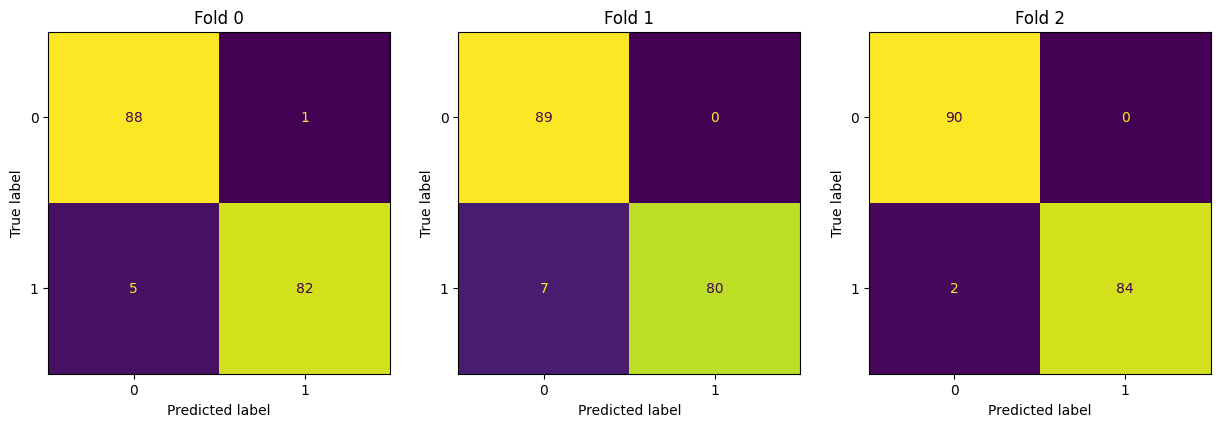

In [20]:
f, axes = plt.subplots(1, nfold, figsize = (nfold*5, 5))
for i in range(nfold):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_ts_over[:, :, i],
                              display_labels = [0, 1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title("Fold %d" % i)
    disp.im_.colorbar.remove()


Khan et al. report an accuracy of 95.52, sensitivity of 93.51, and specificity of 97.13 for the SVM classifier with a "fine" Gaussian kernel. We have essentially matched that result.

## 4. Train an SVM classifier - oversampling with independent test set

The model trained on an oversampled minority class *seems* to be very effective - but in fact, it only appears so due to a data leakage error.

When we oversample the data, new samples are derived from the existing samples. Since we oversample using the *entire* data set all mixed together:

* *test* samples inside the KFold loop will include "new" synthetic samples derived from samples in the *training* set
* and *training* samples inside the KFold loop include "new" synthetic samples derived from samples in the *test* set

Thus, our evaluation will be overly optimistic - we training a model on samples derived from the "test" data, and evaluating it on samples derived from the training data. This is a much easier "task" than training on a training set, and then evaluating on a totally independent test set.

In the next cell, copy the code from the "oversampling" section, but move the oversampling step inside the KFold loop. 

* You will split on the original data, not the oversampled data.
* Create an oversampled training set `Xtr_kfold`, `ytr_kfold` in each fold by oversampling the training data for that fold, 
* and create an oversampled test set `Xts_kfold`, `yts_kfold` in each fold by oversampling the test data for that fold. 

Keep everything else the same.

You will save the same metrics as before, in:
* accuracy (`acc_ts_ind`)
* balanced accuracy (`bal_ts_ind`)
* sensitivity (`sen_ts_ind`)
* specificity (`spe_ts_ind`)
* and the data to generate the confusion matrix (`cm_ts_ind`)

In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 3
acc_ts_ind = np.zeros(nfold)
bal_ts_ind = np.zeros(nfold)
sen_ts_ind = np.zeros(nfold)
spe_ts_ind = np.zeros(nfold)
cm_ts_ind  = np.zeros(shape = (2, 2, nfold))

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_state)
for isplit, (train_index, test_index) in enumerate(skf.split(X, y)):
    Xtr_original = X.iloc[train_index]
    Xts_original = X.iloc[test_index]
    ytr_original = y.iloc[train_index]
    yts_original = y.iloc[test_index]

    adasyn_train = ADASYN(random_state=random_state, n_neighbors=5)
    Xtr_kfold, ytr_kfold = adasyn_train.fit_resample(Xtr_original, ytr_original)

    adasyn_test = ADASYN(random_state=random_state, n_neighbors=5)
    Xts_kfold, yts_kfold = adasyn_test.fit_resample(Xts_original, yts_original)

    clf = SVC(kernel='rbf', random_state=random_state, gamma=0.1, C=10)
    clf.fit(Xtr_kfold, ytr_kfold)
    yhat_ts = clf.predict(Xts_kfold)

    acc_ts_ind[isplit] = accuracy_score(yts_kfold, yhat_ts)
    bal_ts_ind[isplit] = balanced_accuracy_score(yts_kfold, yhat_ts)
    sen_ts_ind[isplit] = recall_score(yts_kfold, yhat_ts)
    spe_ts_ind[isplit] = recall_score(yts_kfold, yhat_ts, pos_label=0)
    cm_ts_ind[:, :, isplit] = confusion_matrix(yts_kfold, yhat_ts, labels=[0, 1])



In [22]:
print("Accuracy:     ", acc_ts_ind.mean())
print("Bal Accuracy: ", bal_ts_ind.mean())
print("Sensitivity:  ", sen_ts_ind.mean())
print("Specificity:  ", spe_ts_ind.mean())

Accuracy:      0.5401450753711889
Bal Accuracy:  0.5344135161334994
Sensitivity:   0.9808429118773946
Specificity:   0.08798412038960439


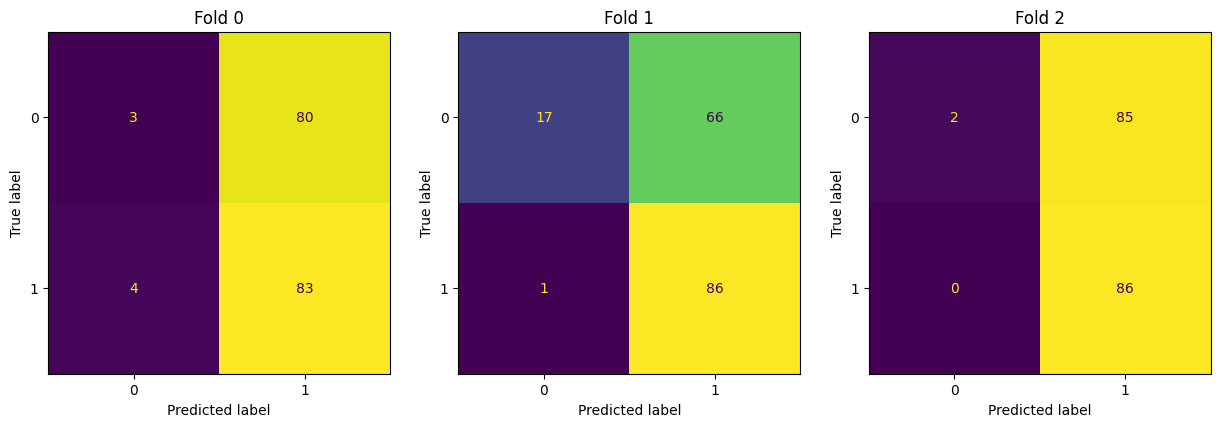

In [23]:
f, axes = plt.subplots(1, nfold, figsize = (nfold*5, 5))
for i in range(nfold):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_ts_ind[:, :, i],
                              display_labels = [0, 1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title("Fold %d" % i)
    disp.im_.colorbar.remove()


## 5. Train an SVM classifier - test set with imbalance

In the example above, we evaluated our classifier on an oversampled test set, so that we can directly compare it to the classifier with data leakage. 

However, since in real use the model will make predictions on imbalanced (real-life) data, our model evaluation should be similar. 

In the following cell, copy the code from the previous section, but this time, 

* Create an oversampled training set `Xtr_kfold`, `ytr_kfold` in each fold by oversampling the training data for that fold, 
* and create the test set `Xts_kfold`, `yts_kfold` in each fold by selecting rows from the original data for that fold. 


Keep everything else the same.

You will save the same metrics as before, in:
* accuracy (`acc_ts_imb`)
* balanced accuracy (`bal_ts_imb`)
* sensitivity (`sen_ts_imb`)
* specificity (`spe_ts_imb`)
* and the data to generate the confusion matrix (`cm_ts_imb`)


In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

nfold = 3
acc_ts_imb = np.zeros(nfold)
bal_ts_imb = np.zeros(nfold)
sen_ts_imb = np.zeros(nfold)
spe_ts_imb = np.zeros(nfold)
cm_ts_imb  = np.zeros(shape = (2, 2, nfold))

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_state)
for isplit, (train_index, test_index) in enumerate(skf.split(X, y)):
    # 选取训练集和测试集的原始数据
    Xtr_original = X.iloc[train_index]
    Xts_original = X.iloc[test_index]
    ytr_original = y.iloc[train_index]
    yts_original = y.iloc[test_index]

    adasyn = ADASYN(random_state=random_state, n_neighbors=5)
    Xtr_kfold, ytr_kfold = adasyn.fit_resample(Xtr_original, ytr_original)

    Xts_kfold = Xts_original
    yts_kfold = yts_original

    clf = SVC(kernel='rbf', random_state=random_state, gamma=0.1, C=10)
    clf.fit(Xtr_kfold, ytr_kfold)

    yhat_ts = clf.predict(Xts_kfold)

    acc_ts_imb[isplit] = accuracy_score(yts_kfold, yhat_ts)
    bal_ts_imb[isplit] = balanced_accuracy_score(yts_kfold, yhat_ts)
    sen_ts_imb[isplit] = recall_score(yts_kfold, yhat_ts)
    spe_ts_imb[isplit] = recall_score(yts_kfold, yhat_ts, pos_label=0)
    cm_ts_imb[:, :, isplit] = confusion_matrix(yts_kfold, yhat_ts, labels=[0, 1])


In [25]:
print("Accuracy:     ", acc_ts_imb.mean())
print("Bal Accuracy: ", bal_ts_imb.mean())
print("Sensitivity:  ", sen_ts_imb.mean())
print("Specificity:  ", spe_ts_imb.mean())

Accuracy:      0.8591582491582491
Bal Accuracy:  0.5043103448275862
Sensitivity:   0.9808429118773946
Specificity:   0.027777777777777776


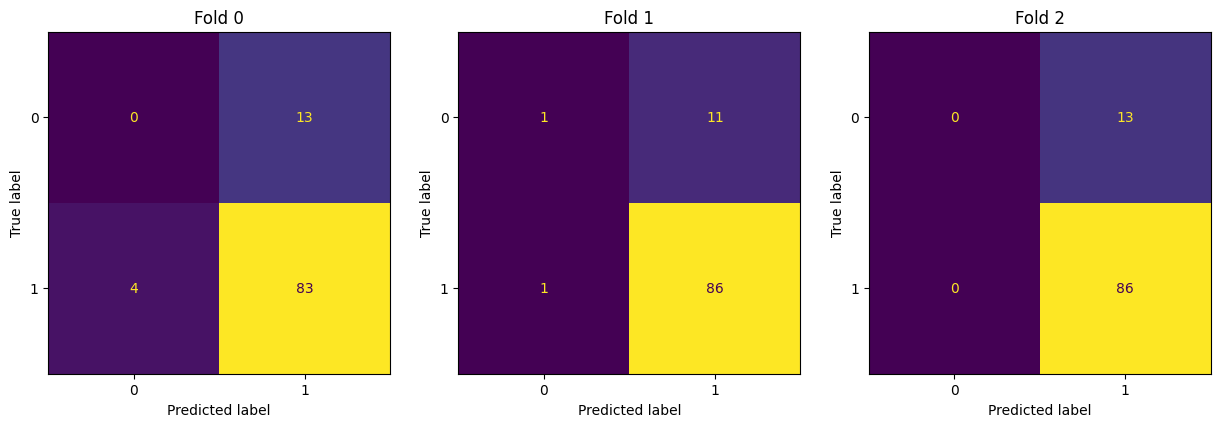

In [26]:
f, axes = plt.subplots(1, nfold, figsize = (nfold*5, 5))
for i in range(nfold):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm_ts_imb[:, :, i],
                              display_labels = [0, 1])
    disp.plot(ax=axes[i])
    disp.ax_.set_title("Fold %d" % i)
    disp.im_.colorbar.remove()


## Conclusion

We can see that the model does not have any predictive benefit over "prediction by mode". The result in the paper by Khan et al. is a **mistake** - their evaluation is not valid, because it is not conducted on an independent test set. 

(And, as demonstrated by Vandewiele et al., a similar mistake is made in many other published papers on this dataset.)